<a href="https://colab.research.google.com/github/kuir-juach/Capstone_final_Project/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:

# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, random, shutil, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout,
                                     Conv2D, MaxPooling2D, Flatten, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from google.colab import files
import math

In [27]:
DATASET_DIR = "/content/drive/MyDrive/data_set_medicinal"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 25
MODEL_SAVE_PATH = "plant_medicinal_mobilenetv2.h5"

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [28]:
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,  # 30% for validation+test
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Split temp_ds into val (20%) and test (10%)
val_size = 0.66  # ~20%
val_batches = int(val_size * tf.data.experimental.cardinality(temp_ds).numpy())

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"✅ Found {num_classes} plant categories: {class_names}")
print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 1737 files belonging to 28 classes.
Using 1216 files for training.
Found 1737 files belonging to 28 classes.
Using 521 files for validation.
✅ Found 28 plant categories: ['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Basale', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Religiosa (Peepal Tree)', 'Guava', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mango', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Neem', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Punica Granatum (Pomegranate)', 'Roxburgh fig', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']
Train batches: 38
Validation batch

In [29]:
import os

try:
    print(f"Listing contents of: {DATASET_DIR}")
    for item in os.listdir(DATASET_DIR):
        print(item)
except FileNotFoundError:
    print(f"Error: The directory {DATASET_DIR} was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Listing contents of: /content/drive/MyDrive/data_set_medicinal
Nyctanthes Arbor-tristis (Parijata)
Piper Betle (Betel)
Syzygium Cumini (Jamun)
Syzygium Jambos (Rose Apple)
Punica Granatum (Pomegranate)
Plectranthus Amboinicus (Mexican Mint)
Ocimum Tenuiflorum (Tulsi)
Santalum Album (Sandalwood)
Tabernaemontana Divaricata (Crape Jasmine)
Trigonella Foenum-graecum (Fenugreek)
Amaranthus Viridis (Arive-Dantu)
Artocarpus Heterophyllus (Jackfruit)
Carissa Carandas (Karanda)
Citrus Limon (Lemon)
Ficus Religiosa (Peepal Tree)
Hibiscus Rosa-sinensis
Jasminum (Jasmine)
Mentha (Mint)
Moringa Oleifera (Drumstick)
Muntingia Calabura (Jamaica Cherry-Gasagase)
Nerium Oleander (Oleander)
Murraya Koenigii (Curry)
Neem
Mango
Guava
Roxburgh fig
Basale
Alpinia Galanga (Rasna)


In [30]:
# 4. Data Pipeline Optimization
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# =====================================
# 5. Data Augmentation
# =====================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

In [31]:
# 6. Build Transfer Learning Model (MobileNetV2)
def build_transfer_model(input_shape=(*IMG_SIZE, 3), num_classes=num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False  # freeze for now

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="mobilenetv2_transfer")
    return model

model = build_transfer_model()
model.summary()

Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,852 (8.75 MB)

 Trainable params: 35,868 (140.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:
# 7. Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# 8. Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')


In [33]:
# 9. Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0266 - loss: 4.0951

38/38 ━━━━━━━━━━━━━━━━━━━━ 300s 8s/step - accuracy: 0.0270 - loss: 4.0909 - val_accuracy: 0.0682 - val_loss: 3.3140 - learning_rate: 1.0000e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0641 - loss: 3.5971

38/38 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.0645 - loss: 3.5933 - val_accuracy: 0.1790 - val_loss: 2.9745 - learning_rate: 1.0000e-04
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1277 - loss: 3.1186

38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.1284 - loss: 3.1163 - val_accuracy: 0.3011 - val_loss: 2.6624 - learning_rate: 1.0000e-04
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1904 - loss: 2.8089

38/38 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.1908 - loss: 2.8065 - val_accuracy: 0.3665 - val_loss: 2.3796 - learning_rate: 1.0000e-04
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2565 - loss: 2.5586

38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2570 - loss: 2.5571 - val_accuracy: 0.4119 - val_loss: 2.1647 - learning_rate: 1.0000e-04
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2898 - loss: 2.3720

38/38 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2908 - loss: 2.3693 - val_accuracy: 0.4659 - val_loss: 1.9818 - learning_rate: 1.0000e-04
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4033 - loss: 2.0835

38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4037 - loss: 2.0822 - val_accuracy: 0.5455 - val_loss: 1.7453 - learning_rate: 1.0000e-04
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4258 - loss: 1.9956

38/38 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.4266 - loss: 1.9934 - val_accuracy: 0.5710 - val_loss: 1.6425 - learning_rate: 1.0000e-04
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4913 - loss: 1.7865

38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4915 - loss: 1.7849 - val_accuracy: 0.5852 - val_loss: 1.5331 - learning_rate: 1.0000e-04
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5358 - loss: 1.6495

38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5358 - loss: 1.6488 - val_accuracy: 0.6278 - val_loss: 1.4460 - learning_rate: 1.0000e-04
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6014 - loss: 1.4784

38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6014 - loss: 1.4783 - val_accuracy: 0.6676 - val_loss: 1.3049 - learning_rate: 1.0000e-04
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6106 - loss: 1.3966

38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6108 - loss: 1.3965 - val_accuracy: 0.6761 - val_loss: 1.2290 - learning_rate: 1.0000e-04
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6497 - loss: 1.3233

38/38 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6497 - loss: 1.3230 - val_accuracy: 0.7386 - val_loss: 1.1427 - learning_rate: 1.0000e-04
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6530 - loss: 1.2644

38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6534 - loss: 1.2633 - val_accuracy: 0.7131 - val_loss: 1.0845 - learning_rate: 1.0000e-04
Epoch 15/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6739 - loss: 1.1882

38/38 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6742 - loss: 1.1875 - val_accuracy: 0.7358 - val_loss: 1.0366 - learning_rate: 1.0000e-04
Epoch 16/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6927 - loss: 1.1403

38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6930 - loss: 1.1392 - val_accuracy: 0.7500 - val_loss: 0.9820 - learning_rate: 1.0000e-04
Epoch 17/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7129 - loss: 1.0537

38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7131 - loss: 1.0533 - val_accuracy: 0.7699 - val_loss: 0.9183 - learning_rate: 1.0000e-04
Epoch 18/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7351 - loss: 1.0137

38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7355 - loss: 1.0126 - val_accuracy: 0.7898 - val_loss: 0.9061 - learning_rate: 1.0000e-04
Epoch 19/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7558 - loss: 0.9224

38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7561 - loss: 0.9220 - val_accuracy: 0.7841 - val_loss: 0.8556 - learning_rate: 1.0000e-04
Epoch 20/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7312 - loss: 0.9726

38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7320 - loss: 0.9707 - val_accuracy: 0.8239 - val_loss: 0.7586 - learning_rate: 1.0000e-04
Epoch 21/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7568 - loss: 0.9048

38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7571 - loss: 0.9042 - val_accuracy: 0.8210 - val_loss: 0.7391 - learning_rate: 1.0000e-04
Epoch 22/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7886 - loss: 0.8410

38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7889 - loss: 0.8401 - val_accuracy: 0.8210 - val_loss: 0.7264 - learning_rate: 1.0000e-04
Epoch 23/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8161 - loss: 0.7947

38/38 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8158 - loss: 0.7946 - val_accuracy: 0.8295 - val_loss: 0.7035 - learning_rate: 1.0000e-04
Epoch 24/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8192 - loss: 0.7549

38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8188 - loss: 0.7551 - val_accuracy: 0.8438 - val_loss: 0.6512 - learning_rate: 1.0000e-04
Epoch 25/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8228 - loss: 0.7110

38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8229 - loss: 0.7110 - val_accuracy: 0.8494 - val_loss: 0.6461 - learning_rate: 1.0000e-04


In [34]:
# 10. Fine-tuning
base_model = model.get_layer("mobilenetv2_1.00_224")
base_model.trainable = True

fine_tune_at = int(0.8 * len(base_model.layers))
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6285 - loss: 1.3405 - val_accuracy: 0.8153 - val_loss: 0.6425 - learning_rate: 1.0000e-05
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7288 - loss: 1.0526 - val_accuracy: 0.8523 - val_loss: 0.5635 - learning_rate: 1.0000e-05
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7707 - loss: 0.8570 - val_accuracy: 0.8693 - val_loss: 0.4893 - learning_rate: 1.0000e-05
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8268 - loss: 0.7197 - val_accuracy: 0.8665 - val_loss: 0.4926 - learning_rate: 1.0000e-05
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.8693 - loss: 0.6182 - val_accuracy: 0.8551 - val_loss: 0.4890 - learning_rate: 1.0000e-05
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8534 - loss: 0.5636 - val_accuracy: 0.8636 - val_loss: 0.4868 - learning_rate: 1.0000e-05
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.8781 

In [35]:
# 11. Evaluate Model

test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 953ms/step - accuracy: 0.8798 - loss: 0.4359

✅ Test Accuracy: 0.8698 | Test Loss: 0.4393


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

📊 Classification Report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       1.00      0.80      0.89         5
            Amaranthus Viridis (Arive-Dantu)       0.90      1.00      0.95         9
        Artocarpus Heterophyllus (Jackfruit)       0.20      1.00      0.33         2
                                      Basale       1.00      0.89      0.94         9
                  Carissa Carandas (Karanda)       1.00      0.88      0.93         8
                        Citrus Limon (Lemon)       1.00      0.78      0.88         9
               Ficus Religiosa (Peepal Tree)       1.00      1.00      1.00         6
                                       Guava       1.00      1.00    

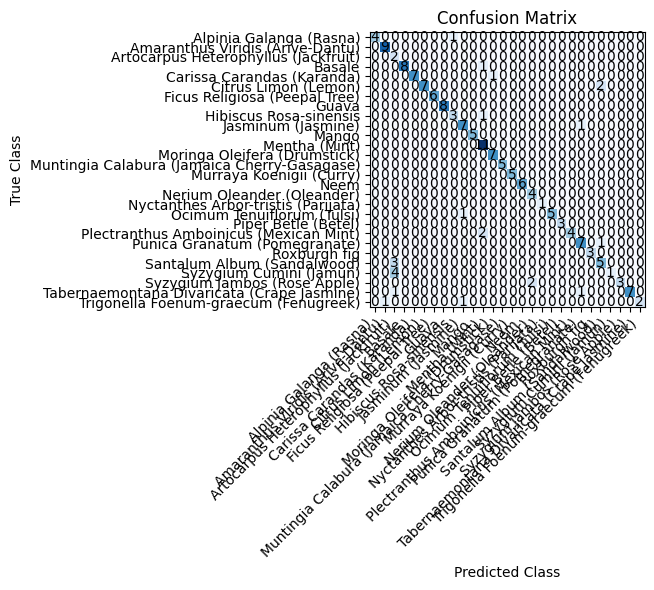


🧩 Interpretation:
The confusion matrix shows how well the model predicts each plant class.
- Diagonal cells represent correct predictions (true positives).
- Off-diagonal cells show misclassifications.
A perfect classifier would have all values along the diagonal.



In [36]:

#12Confusion Matrix & Classification Report
y_true, y_pred = [], []
for images, labels in test_ds.unbatch().batch(BATCH_SIZE):
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

print("""
🧩 Interpretation:
The confusion matrix shows how well the model predicts each plant class.
- Diagonal cells represent correct predictions (true positives).
- Off-diagonal cells show misclassifications.
A perfect classifier would have all values along the diagonal.
""")


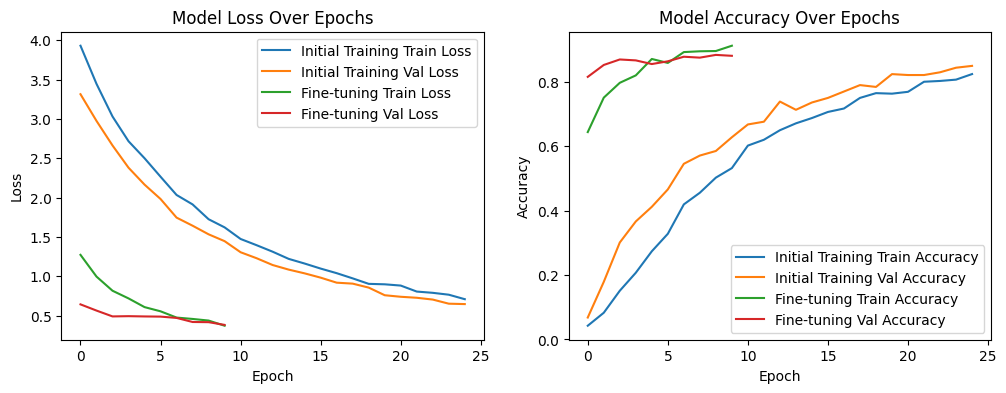


📈 Interpretation of Training Curves:
- The **loss curve** indicates how much the model’s predictions differ from the actual values.
  - A decreasing loss over epochs means the model is learning effectively.
  - If validation loss starts increasing, it may indicate overfitting.
- The **accuracy curve** shows how well the model performs on training and validation data.
  - Consistent growth in accuracy with stable validation accuracy indicates good generalization.
  - The fine-tuning phase should slightly improve validation accuracy and stabilize loss.



In [37]:
# 13. Plot Training Curves
def plot_history(histories):
    plt.figure(figsize=(12,4))

    # Loss Plot
    plt.subplot(1,2,1)
    for h, label in zip(histories, ['Initial Training', 'Fine-tuning']):
        plt.plot(h.history['loss'], label=f'{label} Train Loss')
        plt.plot(h.history['val_loss'], label=f'{label} Val Loss')
    plt.legend()
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Accuracy Plot
    plt.subplot(1,2,2)
    for h, label in zip(histories, ['Initial Training', 'Fine-tuning']):
        plt.plot(h.history['accuracy'], label=f'{label} Train Accuracy')
        plt.plot(h.history['val_accuracy'], label=f'{label} Val Accuracy')
    plt.legend()
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.show()

plot_history([history, fine_tune_history])

print("""
📈 Interpretation of Training Curves:
- The **loss curve** indicates how much the model’s predictions differ from the actual values.
  - A decreasing loss over epochs means the model is learning effectively.
  - If validation loss starts increasing, it may indicate overfitting.
- The **accuracy curve** shows how well the model performs on training and validation data.
  - Consistent growth in accuracy with stable validation accuracy indicates good generalization.
  - The fine-tuning phase should slightly improve validation accuracy and stabilize loss.
""")

In [38]:
# 14. Save Model
model.save(MODEL_SAVE_PATH)
print(f"\n💾 Final model saved as {MODEL_SAVE_PATH}")


💾 Final model saved as plant_medicinal_mobilenetv2.h5
